# Can **you** break computer vision model?
## On-site round

## Task 1: Break a network by hand



Suppose you have a neural network $M$, defined b $M(x) = \text{softmax}\left(x^\top\theta\right)$. Note that for $z\in\mathbb{R}^n$ we have $\text{softmax}(z)=\frac{1}{\sum_i \exp(z_i)}\cdot\left[\exp(z_1), \exp(z_2), \ldots, \exp(z_n)\right]$.

Further, let $x=[1.,2.,3.]$ be an input of interest and let $\theta=\begin{bmatrix}
    5. & -2. \\
    3. & 4. \\
    2. & -1.
\end{bmatrix}$. Compute an an adversarial example $x^\prime$ that maximizes the second coordinate of $M(x)$ under the constraint that $\|x^\prime-x\|_\infty \leq 1.$, i.e., you're creating an $\ell_\infty$ adversarial example with $\varepsilon=1$.

Your solution here



## Task 2: Alice heard you've attacked her latest model, so she created a new one! Can you break that one too?

Alice heard about your adaptive attack on AliceNet, so she's raised the bar with her latest robust model, AliceNetV2. According to her, there's no way to attack this new model!
Like last time, Alice won't share with you what her defense is!

Your task is to develop an adaptive *targeted* attack. In particular, you must find a way to make small perturbations to the input images such that AliceNetV2 outputs the class "dog" every time!

###Task Requirements

1. **Understand the Defense**: Analyze Alice's model to understand the type of defense implemented. This could involve reviewing the model architecture, preprocessing steps, or any additional mechanisms employed for defense.

2. **Design an Adaptive Targeted Attack**: Develop an attack strategy that goes around Alice's defense and makes AliceNetV2 output the calss "dog". This might involve modifying standard attack methods like PGD.

3. **Generate Adversarial Examples**: Modify all test images from the CIFAR-10 dataset using your adversarial attack. You are allowed to modify the original test images within an $\ell_\infty$ ball of radius $8/255$.

4. **Test Model Accuracy**: Evaluate how often the AliceNetV2 model predicts the label "dog" on these adversarially modified images.


###Deliverables

* Python code used for your attack and generation of the adversarial CIFAR-10 test set.
* A short (up to a few paragraphs) report detailing your analysis of the defense, the approach used for the adaptive attack, and the success rate of your attack on the CIFAR-10 test set.


In [ ]:
!pip install wget
import wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1e691e0f06b1349dd6cc40a3062ec17d3308a9305547ed6ba94bfa96e6a995f6
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)



def recursive_getattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)

    return functools.reduce(_getattr, [obj] + attr.split("."))


class AliceNetV2_inner(nn.Module):
    KERNEL_SIZE = 3
    IN_CHANNELS = 3
    AVG_POOL_SIZE = 8
    LINEAR_MUL = 4 * 4

    def __init__(self, num_blocks=2, in_planes=64, num_classes=10, debug=False):
        super().__init__()
        self.num_classes = num_classes
        self.debug = debug
        self.in_planes = in_planes
        self.kernel_size = self.KERNEL_SIZE
        self.num_blocks = num_blocks

        # pre-layer stuff
        self.conv1 = nn.Conv2d(
            self.IN_CHANNELS,
            self.in_planes,
            kernel_size=self.kernel_size,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(self.in_planes)

        # make single layer with K BasicBlocks
        # BasicBLock: conv1, bn1, conv2, bn2, shortcut
        # each conv has `in_planes` filters
        get_block = lambda: BasicBlock(self.in_planes, self.in_planes, stride=1)
        self.layer = nn.Sequential(*[get_block() for _ in range(num_blocks)])

        # register blocks with setattr to make it compatible with masking code
        for idx, block in enumerate(self.layer):
            setattr(self, f"block{idx}", block)

        # post-layer stuff
        self.flatten = nn.Flatten()
        self.avg_pool_2d = nn.AvgPool2d(self.AVG_POOL_SIZE)
        self.linear = nn.Linear(self.in_planes * self.LINEAR_MUL, num_classes)

    def forward(self, x, *args, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.debug:
            print(f"conv1: {out.shape}")
        out = self.layer(out)
        if self.debug:
            print(f"layer: {out.shape}")
        out = self.avg_pool_2d(out)
        if self.debug:
            print(f"avg_pool_2d: {out.shape}")
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_components(self, add_weight_suffix=True):
        comps = ["conv1"]
        num_convs = 2
        for block_idx in range(self.num_blocks):
            for conv_idx in range(1, 1 + num_convs):
                comps.append(f"block{block_idx}.conv{conv_idx}")

        comps.append("linear")

        if add_weight_suffix:
            return ["{}.weight".format(c) for c in comps]
        return comps

    def get_component_dimensions(self):
        comps = self.get_components()
        comps_map = {}

        for c in comps:
            w = recursive_getattr(self, c)
            comps_map[c] = w.shape[0]

        return comps_map

class AliceNetV2(nn.Module):
    def __init__(self, num_blocks=2, in_planes=64, num_classes=10):
        super(AliceNetV2, self).__init__()
        self.model1 = AliceNetV2_inner(num_blocks=num_blocks, in_planes=in_planes, num_classes=num_classes)
        self.model2 = AliceNetV2_inner(num_blocks=num_blocks, in_planes=in_planes, num_classes=num_classes)
        self.model3 = AliceNetV2_inner(num_blocks=num_blocks, in_planes=in_planes, num_classes=num_classes)

    def forward(self, x):
        outputs = []
        for network in [self.model1, self.model2, self.model3]:
            out = network(x)
            outputs.append(out)
        outputs = torch.stack(outputs)
        network_predictions = torch.argmax(outputs, dim=-1)
        majority_votes = torch.mode(network_predictions, dim=0).values
        result = torch.zeros_like(out)
        for i, vote in enumerate(majority_votes):
            result[i, vote] = 1.
        return result


def get_alicenet_v2() -> AliceNetV2:

    model = AliceNetV2()

    url = 'https://www.dropbox.com/scl/fi/awpcptjv4jbrgljn58k0m/alice_model_v2_IOAI.pt?rlkey=1v9hzkkpyqm0xqcyl1dogfwz8&dl=1'
    wget.download(url, out='./alicenet_v2.pt', bar=None)
    trained_ckpt = torch.load('./alicenet_v2.pt', map_location="cpu")
    model.load_state_dict(trained_ckpt)

    return model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AliceNetV2
model = get_alicenet_v2().to(device)
model.eval()

# Define targeted attack (target class is dog, which is class 5 in CIFAR-10)
target_class = 5

def targeted_pgd_attack(model, images, labels, epsilon=8/255, alpha=2/255, num_iter=100):
    """
    Targeted PGD attack against the AliceNetV2 ensemble
    Goal: Make the model predict 'dog' (class 5) for all inputs
    """
    images = images.clone().detach().to(device)
    labels = torch.full((images.size(0),), target_class, device=device)  # All targets are 'dog'

    # Initialize perturbation
    perturbation = torch.zeros_like(images, requires_grad=True)

    # Create adversarial examples
    for _ in range(num_iter):
        perturbed_images = images + perturbation
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        # Zero gradients
        if perturbation.grad is not None:
            perturbation.grad.zero_()

        # Forward pass through all three models
        outputs = []
        for network in [model.model1, model.model2, model.model3]:
            out = network(perturbed_images)
            outputs.append(out)
        outputs = torch.stack(outputs, dim=0)  # [3, batch_size, num_classes]

        # Compute loss - we want to maximize probability of dog class in at least 2 models
        # We'll use the average of the two worst (least dog-friendly) models
        dog_probs = outputs[:, :, target_class]  # [3, batch_size]
        sorted_probs, _ = torch.sort(dog_probs, dim=0)
        loss = -sorted_probs[1].mean()  # Target the median probability

        # Backward pass
        loss.backward()

        # Update perturbation
        perturbation.data = perturbation.data - alpha * perturbation.grad.sign()
        perturbation.data = torch.clamp(perturbation.data, -epsilon, epsilon)

    # Final perturbed images
    adv_images = images + perturbation.detach()
    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images

# Load CIFAR-10 test set
transform = transforms.Compose([transforms.ToTensor()])
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Generate adversarial examples for all test images
all_adv_images = []
all_labels = []

for images, labels in tqdm(testloader, desc="Generating adversarial examples"):
    adv_images = targeted_pgd_attack(model, images, labels)
    all_adv_images.append(adv_images.cpu())
    all_labels.append(labels)

all_adv_images = torch.cat(all_adv_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)


Generating adversarial examples: 100%|██████████| 157/157 [14:22<00:00,  5.50s/it]


In [ ]:
import matplotlib.pyplot as plt

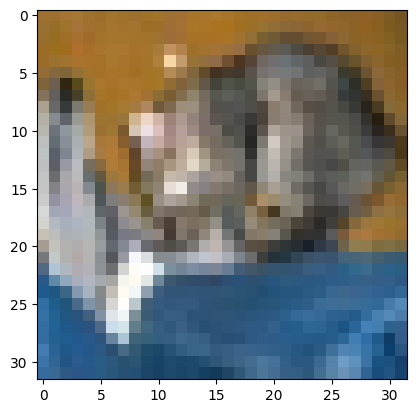

In [ ]:
plt.imshow(testset[0][0].permute(1,2,0))

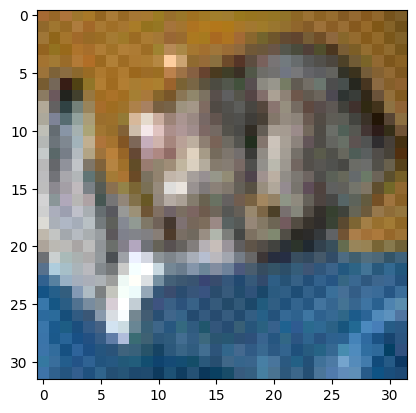

In [ ]:
plt.imshow(all_adv_images[0].permute(1,2,0))

In [ ]:
# Verify attack success rate 96ю48 - 50
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, len(all_adv_images),64):
        batch_images = all_adv_images[i:i+64].to(device)
        outputs = model(batch_images)
        _, predicted = outputs.max(1)
        correct += (predicted == target_class).sum().item()
        total += predicted.size(0)

print(f"Attack success rate: {100 * correct / total:.2f}%")

Attack success rate: 96.58%
